In [1]:
import torch
from diffusers import StableDiffusionPipeline, DDIMScheduler
from huggingface_hub import login

#---------------------------------------------------------
#---  Зайти на https://huggingface.co и создать токен  ---
#---      https://huggingface.co/settings/tokens       ---
#---------------------------------------------------------
# И поставить в настройках блокнота GPU
login(token="YOUR_TOKEN")

pipe = StableDiffusionPipeline.from_pretrained("stable-diffusion-v1-5/stable-diffusion-v1-5", torch_dtype=torch.float16)
pipe = pipe.to("cuda")

# Проверяем, что все компоненты модели в FP16 и на cuda
assert pipe.unet.dtype == torch.float16 and pipe.unet.device.type == 'cuda'
assert pipe.vae.dtype == torch.float16 and pipe.vae.device.type == 'cuda'
assert pipe.text_encoder.dtype == torch.float16 and pipe.text_encoder.device.type == 'cuda'

# Заменяем дефолтный сэмплер на DDIM
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config, timestep_spacing="trailing")
pipe.scheduler.timesteps = pipe.scheduler.timesteps.cuda()
pipe.scheduler.alphas_cumprod = pipe.scheduler.alphas_cumprod.cuda()

# Отдельно извлечем модель учителя, которую потом будем дистиллировать
teacher_unet = pipe.unet

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [4]:
import matplotlib.pyplot as plt

def visualize_images(images):
    assert len(images) == 4
    plt.figure(figsize=(12, 3))
    for i, image in enumerate(images):
        plt.subplot(1, 4, i+1)
        plt.imshow(image)
        plt.axis('off')

    plt.subplots_adjust(wspace=-0.01, hspace=-0.01)

  0%|          | 0/50 [00:00<?, ?it/s]

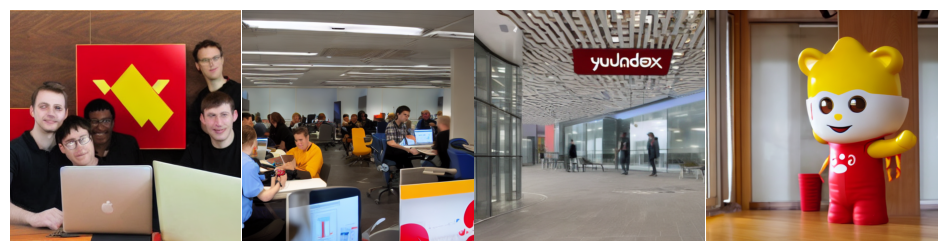

In [5]:
prompt = "Junior developer at Yandex"
guidance_scale = 7.5
generator = torch.Generator('cuda').manual_seed(1)
num_images_per_prompt = 4

images = pipe(prompt, guidance_scale=guidance_scale, generator=generator, num_images_per_prompt=num_images_per_prompt).images

visualize_images(images)